# Gluon /PDF Ratio From EPPS21 nPDF Set

Link here, [click](https://research.hip.fi/qcdtheory/nuclear-pdfs/epps21/).

In [1]:
# --- setup (nPDF only) ---
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from pathlib import Path
sys.path.append("../npdf_code")
import numpy as np, matplotlib.pyplot as plt
from gluon_ratio import EPPS21Ratio, GluonEPPSProvider, WoodsSaxon

# EPPS + provider (gluon flavour fixed internally)
epps  = EPPS21Ratio(A=208, path="../input/npdf/nPDFs")
gprov = GluonEPPSProvider(epps, sqrt_sNN_GeV=5023.0,
                          m_state_GeV="charmonium", y_sign_for_xA=-1).with_geometry(WoodsSaxon(A=208))
gprov8 = GluonEPPSProvider(epps, sqrt_sNN_GeV=8160.0,
                          m_state_GeV="charmonium", y_sign_for_xA=-1).with_geometry(WoodsSaxon(A=208))

In [2]:
# sanity: tables & flavours
print("sets:", epps.n_sets())             # 107
print(epps.list_sets()[1], "→ central")   # central
print(epps.list_flavours())               # {'uv':1,...,'g':8}

sets: 107
central → central
{'uv': 1, 'dv': 2, 'u': 3, 'd': 4, 's': 5, 'c': 6, 'b': 7, 'g': 8, 'gluon': 8, 'gl': 8}


In [48]:
import numpy as np

cent_bins = [0,20,40,60,80,100]  # edit as needed

def b_for_centrality_bins(gprov, edges_pct, sigmaNN_mb=71.0):
    """Return [(label, b_mean_fm, alpha_bar), ...] for each centrality bin."""
    gprov.with_geometry()
    b, T, w = gprov._geom.inel_pdf(sigmaNN_mb=sigmaNN_mb)     # b-grid, thickness, weight
    # CDF of total inelastic probability (for edge finding)
    cdf = np.r_[0.0, np.cumsum(0.5*(w[1:]+w[:-1])*np.diff(b))]

    def inv_cdf(p):
        j = int(np.searchsorted(cdf, p, side="left"))
        if j <= 0:  return float(b[0])
        if j >= len(b): return float(b[-1])
        frac = 0.0 if (cdf[j]-cdf[j-1])==0 else (p - cdf[j-1])/(cdf[j]-cdf[j-1])
        return float((1.0-frac)*b[j-1] + frac*b[j])

    out = []
    T0 = float(T[0])
    for L, R in zip(edges_pct[:-1], edges_pct[1:]):
        bl, br = inv_cdf(L/100.0), inv_cdf(R/100.0)
        m = (b >= bl) & (b < br)
        if not np.any(m):
            out.append((f"{L}-{R}%", np.nan, np.nan))
            continue
        den   = float(np.trapezoid(w[m], b[m]))
        bmean = float(np.trapezoid(b[m]*w[m], b[m]) / den)
        # bin-averaged alpha
        alpha_bar = float(np.trapezoid((T[m]/T0)*w[m], b[m]) / den)
        out.append((f"{L}-{R}%", bmean, alpha_bar))
    return out

bins_info = b_for_centrality_bins(gprov, cent_bins)
for lab, bmean, a_bar in bins_info:
    print(f"{lab:<8}  b̄ = {bmean:5.2f} fm   ᾱ = {a_bar:6.3f}")
    
import matplotlib.pyplot as plt
from cycler import cycler

def color_cycle(n):
    # take first n colors from default cycler
    return [plt.rcParams['axes.prop_cycle'].by_key()['color'][i % 10] for i in range(n)]

def plot_band(ax, x, y_lo, y_hi, color, label=None, alpha=0.25):
    ax.fill_between(x, y_lo, y_hi, color=color, alpha=alpha, linewidth=0, label=label)

# choose b-values: head-on (0 fm) + representative per centrality bin
b_list = [b for _, b, _ in bins_info]
labels = [lab for lab, _, _ in bins_info]
colors = color_cycle(len(b_list))

0-20%     b̄ =  2.36 fm   ᾱ =  0.922
20-40%    b̄ =  4.32 fm   ᾱ =  0.738
40-60%    b̄ =  5.60 fm   ᾱ =  0.494
60-80%    b̄ =  6.65 fm   ᾱ =  0.226
80-100%   b̄ =  7.93 fm   ᾱ =  0.051


## Gluon Ratios

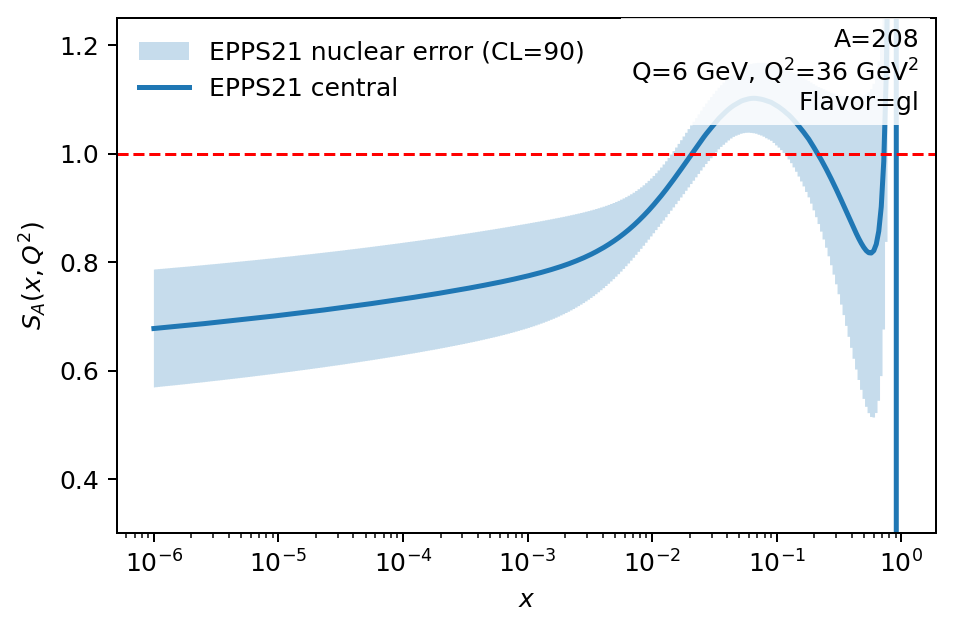

In [49]:
# 1) Gluon ratio S_A(x,Q^2)
x = np.logspace(-6, 0, 300); Q = 6.0
fig, ax = epps.plot_SA_vs_x("g", x, Q)
plt.axhline(1.0, color='red', ls='--', lw=1.2)

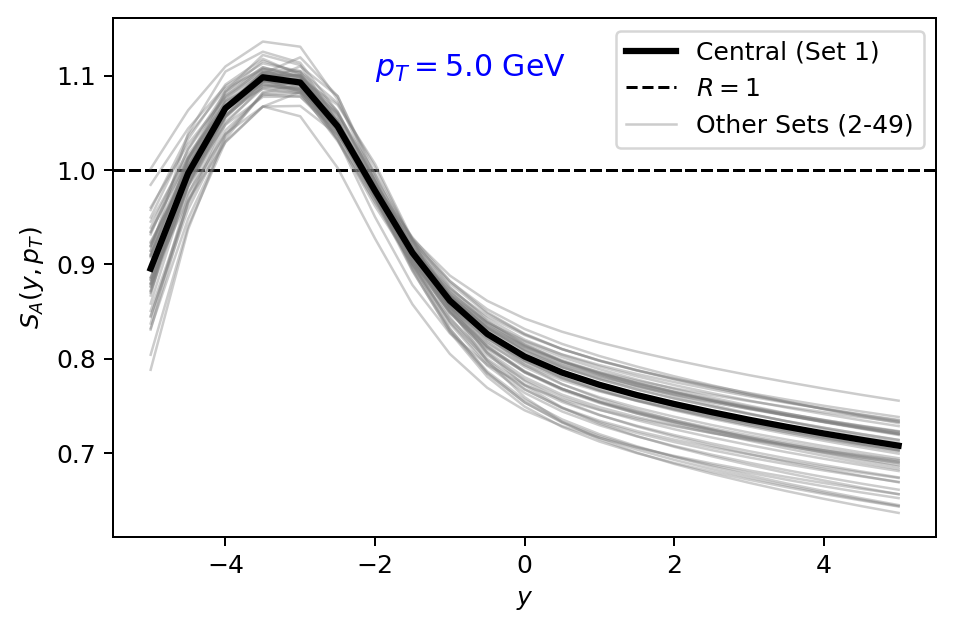

In [92]:
# 1) Define variables
y = np.linspace(-5, 5, 21)
pt = 5.0
b1=5.0
b2=2.5
# 2) Run setup line (as in your example)
try:
    epps.ratio_ypt("g", y, pt, sqrt_sNN_GeV=8160.0, m_state_GeV="charmonium")
except Exception as e:
    print(f"Note: epps.ratio_ypt call failed, continuing to plot. Error: {e}")

# 3) Create the figure
plt.figure(figsize=(5.4, 3.6), dpi=180)

# 4) Loop over all set_ids from 1 to 49
for i in range(1, 50):
    # Calculate SA for the current set_id
    SA = gprov.SA_ypt_set(y, pt, set_id=i)

    if i == 1:
        # Plot set 1 (Central) darker and thicker
        plt.plot(y, SA, lw=2.5, color='black', label="Central (Set 1)", zorder=20)
    else:
        # Plot other sets (2-49) lighter and thinner
        # Add a label only for the first "other" set (i=2) for the legend
        label = "Other Sets (2-49)" if i == 2 else None
        plt.plot(y, SA, lw=1, color='gray', alpha=0.4, label=label, zorder=10)
    plt.axhline(1.0, color='black', ls='--', lw=1.2, label=r"$R = 1$" if i == 1 else None)

# 5) Add labels and legend
plt.text(-2, 1.1, rf'$p_T = {pt}$ GeV', fontsize=12, color='blue')
plt.xlabel(r"$y$")
plt.ylabel(r"$S_{A}(y,p_T)$")
plt.legend(frameon=True)
plt.tight_layout()

In [ ]:
# 1) Define variables
y = np.linspace(-5, 5, 21)
pt = 5.0
b1=5.0
b2=2.5
# 2) Run setup line (as in your example)
try:
    epps.ratio_ypt("g", y, pt, sqrt_sNN_GeV=8160.0, m_state_GeV="charmonium")
except Exception as e:
    print(f"Note: epps.ratio_ypt call failed, continuing to plot. Error: {e}")

# 3) Create the figure
plt.figure(figsize=(5.4, 3.6), dpi=180)

# 4) Loop over all set_ids from 1 to 49
for i in range(1, 50):
    # Calculate SA for the current set_id
    SA = gprov.SA_ypt_set(y, np.full_like(y, pt), set_id=i)

    # SAWS (b=fixed)
    SAWS = gprov.SAWS_ypt_b_set(y,  np.full_like(y, pt), b=b1, set_id=1)
    SAWS2 = gprov.SAWS_ypt_b_set(y,  np.full_like(y, pt), b=b2, set_id=1) 
    
    KAWS=    SAWS /SA
    KAWS2=    SAWS2 /SA

    if i == 1:
        # Plot set 1 (Central) darker and thicker
        plt.plot(y, SA, lw=2.5, color='black', label="Central (Set 1)", zorder=50)
    else:
        # Plot other sets (2-49) lighter and thinner
        # Add a label only for the first "other" set (i=2) for the legend
        label = "Other Sets (2-49)" if i == 2 else None
        plt.plot(y, SA, lw=1, color='gray', alpha=0.7, label=label, zorder=10)
    plt.axhline(1.0, color='black', ls='--', lw=1.2, label=r"$R = 1$" if i == 1 else None)
    plt.plot(y, KAWS, lw=1, color='purple', alpha=0.7, zorder=10)
    plt.plot(y, KAWS2, lw=1, color='orange', alpha=0.7, zorder=10)
plt.plot(y, SAWS, lw=1, color='purple', alpha=0.7, label=f"S_AWS(b={b1})", zorder=10)
plt.plot(y, SAWS2, lw=1, color='orange', alpha=0.7, label=f"S_AWS(b={b2})", zorder=10)
# 5) Add labels and legend
plt.text(-2, 1.1, rf'$p_T = {pt}$ GeV', fontsize=12, color='blue')
plt.xlabel(r"$y$")
plt.ylabel(r"$S_{A}(y,p_T)$")
plt.legend(frameon=True)
plt.tight_layout()

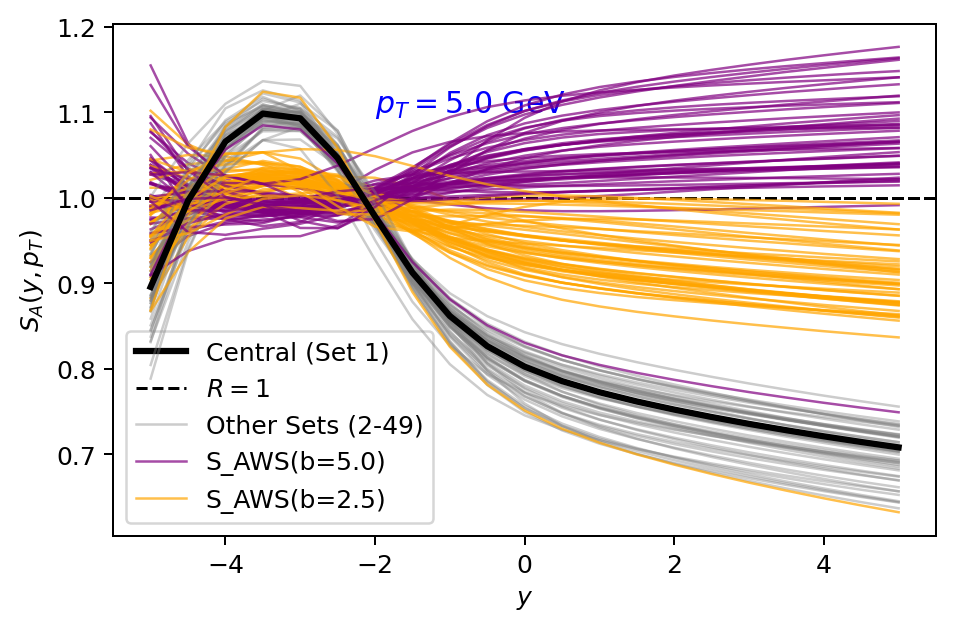

In [45]:
# 1) Define variables
y = np.linspace(-5, 5, 21)
pt = 5.0
b1=5.0
b2=2.5
# 2) Run setup line (as in your example)
try:
    epps.ratio_ypt("g", y, pt, sqrt_sNN_GeV=8160.0, m_state_GeV="charmonium")
except Exception as e:
    print(f"Note: epps.ratio_ypt call failed, continuing to plot. Error: {e}")

# 3) Create the figure
plt.figure(figsize=(5.4, 3.6), dpi=180)

# 4) Loop over all set_ids from 1 to 49
for i in range(1, 50):
    # Calculate SA for the current set_id
    SA = gprov.SA_ypt_set(y, pt, set_id=i)

    # SAWS (b=fixed)
    SAWS = gprov.SAWS_ypt_b_set(y,  pt, b=b1, set_id=1)
    SAWS2 = gprov.SAWS_ypt_b_set(y, pt, b=b2, set_id=1) 
    
    KAWS=    SAWS /SA
    KAWS2=    SAWS2 /SA

    if i == 1:
        # Plot set 1 (Central) darker and thicker
        plt.plot(y, SA, lw=2.5, color='black', label="Central (Set 1)", zorder=20)
    else:
        # Plot other sets (2-49) lighter and thinner
        # Add a label only for the first "other" set (i=2) for the legend
        label = "Other Sets (2-49)" if i == 2 else None
        plt.plot(y, SA, lw=1, color='gray', alpha=0.4, label=label, zorder=10)
    plt.axhline(1.0, color='black', ls='--', lw=1.2, label=r"$R = 1$" if i == 1 else None)
    plt.plot(y, KAWS, lw=1, color='purple', alpha=0.7, zorder=10)
    plt.plot(y, KAWS2, lw=1, color='orange', alpha=0.7, zorder=10)
plt.plot(y, SAWS, lw=1, color='purple', alpha=0.7, label=f"S_AWS(b={b1})", zorder=10)
plt.plot(y, SAWS2, lw=1, color='orange', alpha=0.7, label=f"S_AWS(b={b2})", zorder=10)
# 5) Add labels and legend
plt.text(-2, 1.1, rf'$p_T = {pt}$ GeV', fontsize=12, color='blue')
plt.xlabel(r"$y$")
plt.ylabel(r"$S_{A}(y,p_T)$")
plt.legend(frameon=True)
plt.tight_layout()

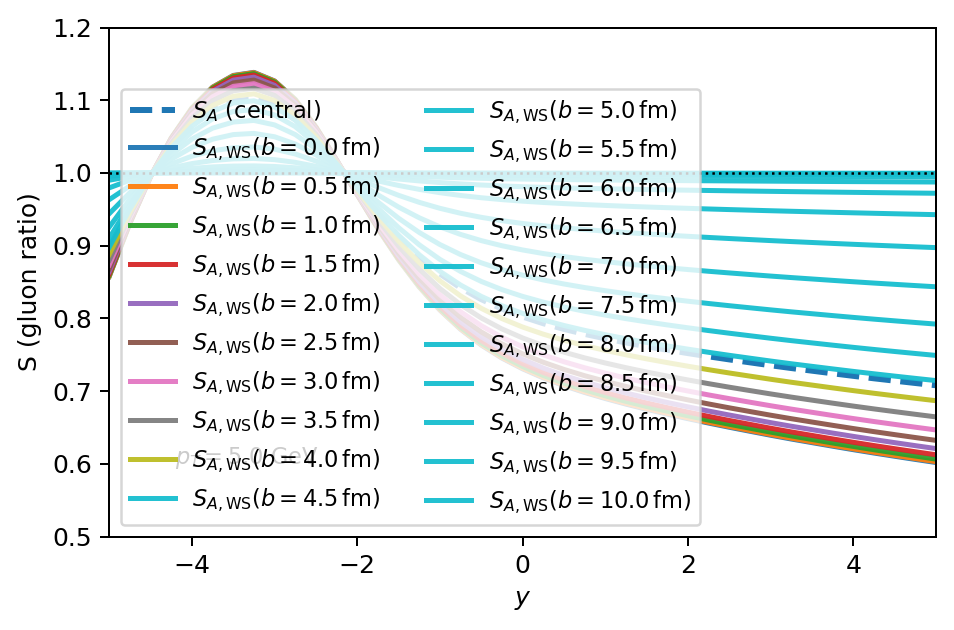

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps  # modern way instead of get_cmap

# ---------------- settings ----------------
y  = np.linspace(-5.0, 5.0, 41)
pt = 5.0

b_vals = b_list # [2.5, 4.0, 5.0, 6.0, 8.0]    # impact parameters you want to show

# Optional warm-up call so EPPS tables are loaded
try:
    _ = epps.ratio_ypt("g", y, np.full_like(y, pt),
                       sqrt_sNN_GeV=8160.0, m_state_GeV="charmonium")
except Exception as e:
    print(f"Note: warm-up epps.ratio_ypt failed (ok to ignore): {e}")

fig, ax = plt.subplots(figsize=(5.4, 3.6), dpi=180)

color_SA = "tab:blue"   # color for S_A
ls_SA    = "--"         # S_A = dashed

# distinct colors for each b
cmap = colormaps["tab10"]
colors_b = {b: cmap(i) for i, b in enumerate(b_vals)}

y_arr  = y

# ---------- S_A: ONLY CENTRAL (dashed, bold) ----------
SA_c = gprov.SA_ypt_set(y_arr, pt, set_id=1)
ax.plot(
    y_arr, SA_c,
    color=color_SA,
    lw=2.4,
    ls=ls_SA,
    label=rf"$S_A$ (central)"
)

# ---------- S_AWS(b): central only, multiple distinct colors ----------
for b in b_vals:
    SAWS_c = gprov.SAWS_ypt_b_set(y_arr, pt, b=b, set_id=1)
    label  = rf"$S_{{A,\mathrm{{WS}}}}(b={b:.1f}\,\mathrm{{fm}})$"
    ax.plot(
        y_arr, SAWS_c,
        color=colors_b[b],
        lw=2.0,
        ls="-",       # solid
        alpha=0.95,
        label=label
    )

# Reference line S = 1
ax.axhline(1.0, color="black", ls=":", lw=1.0)

# Axes labels & limits
ax.set_xlabel(r"$y$")
ax.set_ylabel("S (gluon ratio)")
ax.set_xlim(y[0], y[-1])# 
ax.set_ylim(0.5, 1.2)

# Small text box for pT info
ax.text(
    0.08, 0.18,
    rf"$p_T = {pt:.1f}$ GeV",
    transform=ax.transAxes,
    va="top", ha="left",
    fontsize=9,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
)

ax.legend(frameon=True, fontsize=9, ncol=2)
fig.tight_layout()

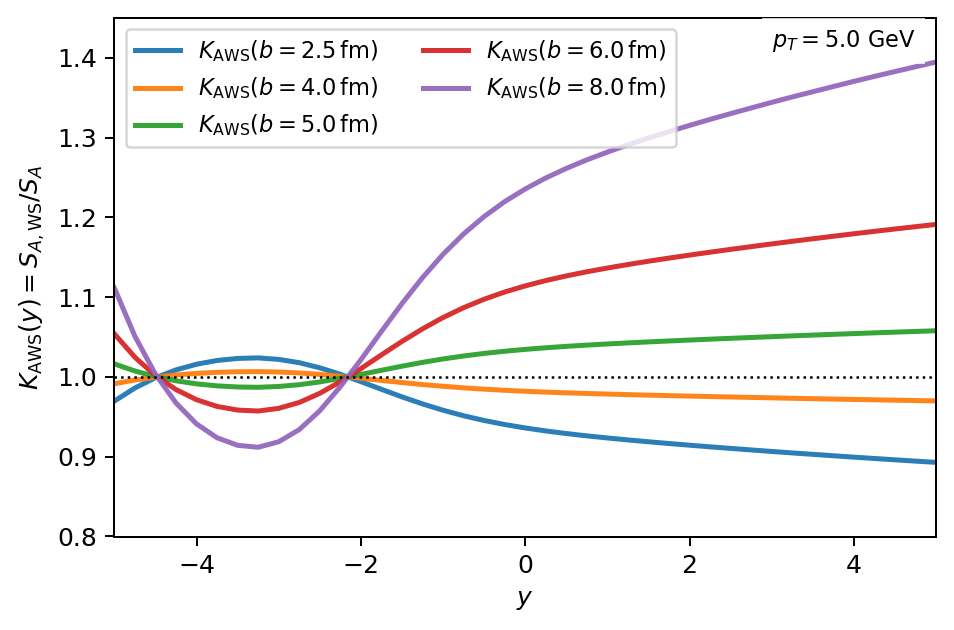

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

# ---------------- settings ----------------
y  = np.linspace(-5.0, 5.0, 41)
pt = 5.0

b_vals = [2.5, 4.0, 5.0, 6.0, 8.0]    # impact parameters you want to show

# Optional warm-up call so EPPS tables are loaded
try:
    _ = epps.ratio_ypt("g", y, np.full_like(y, pt),
                       sqrt_sNN_GeV=8160.0, m_state_GeV="charmonium")
except Exception as e:
    print(f"Note: warm-up epps.ratio_ypt failed (ok to ignore): {e}")

fig, ax = plt.subplots(figsize=(5.4, 3.6), dpi=180)

# distinct colors for each b
cmap = colormaps["tab10"]
colors_b = {b: cmap(i) for i, b in enumerate(b_vals)}

y_arr  = y
pt_arr = np.full_like(y_arr, pt)

# ---------- S_A central ----------
SA_c = gprov.SA_ypt_set(y_arr, pt_arr, set_id=1)

# ---------- Plot K_AWS = SAWS / SA ----------
for b in b_vals:
    SAWS_c = gprov.SAWS_ypt_b_set(y_arr, pt_arr, b=b, set_id=1)
    KAWS = SAWS_c / SA_c

    label = rf"$K_{{\mathrm{{AWS}}}}(b={b:.1f}\,\mathrm{{fm}})$"
    
    ax.plot(
        y_arr, KAWS,
        color=colors_b[b],
        lw=2.0,
        ls="-",            # all solid
        alpha=0.95,
        label=label
    )

# Reference line K = 1
ax.axhline(1.0, color="black", ls=":", lw=1.0)

# Axes labels & limits
ax.set_xlabel(r"$y$")
ax.set_ylabel(r"$K_{\mathrm{AWS}}(y) = S_{A,\mathrm{WS}} / S_A$")
ax.set_xlim(y[0], y[-1])
ax.set_ylim(0.8, 1.45)   # adjust depending on behavior

# Small text box for pT info
ax.text(
    0.8, 0.98,
    rf"$p_T = {pt:.1f}$ GeV",
    transform=ax.transAxes,
    va="top", ha="left",
    fontsize=9,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
)

ax.legend(frameon=True, fontsize=9, ncol=2)
fig.tight_layout()

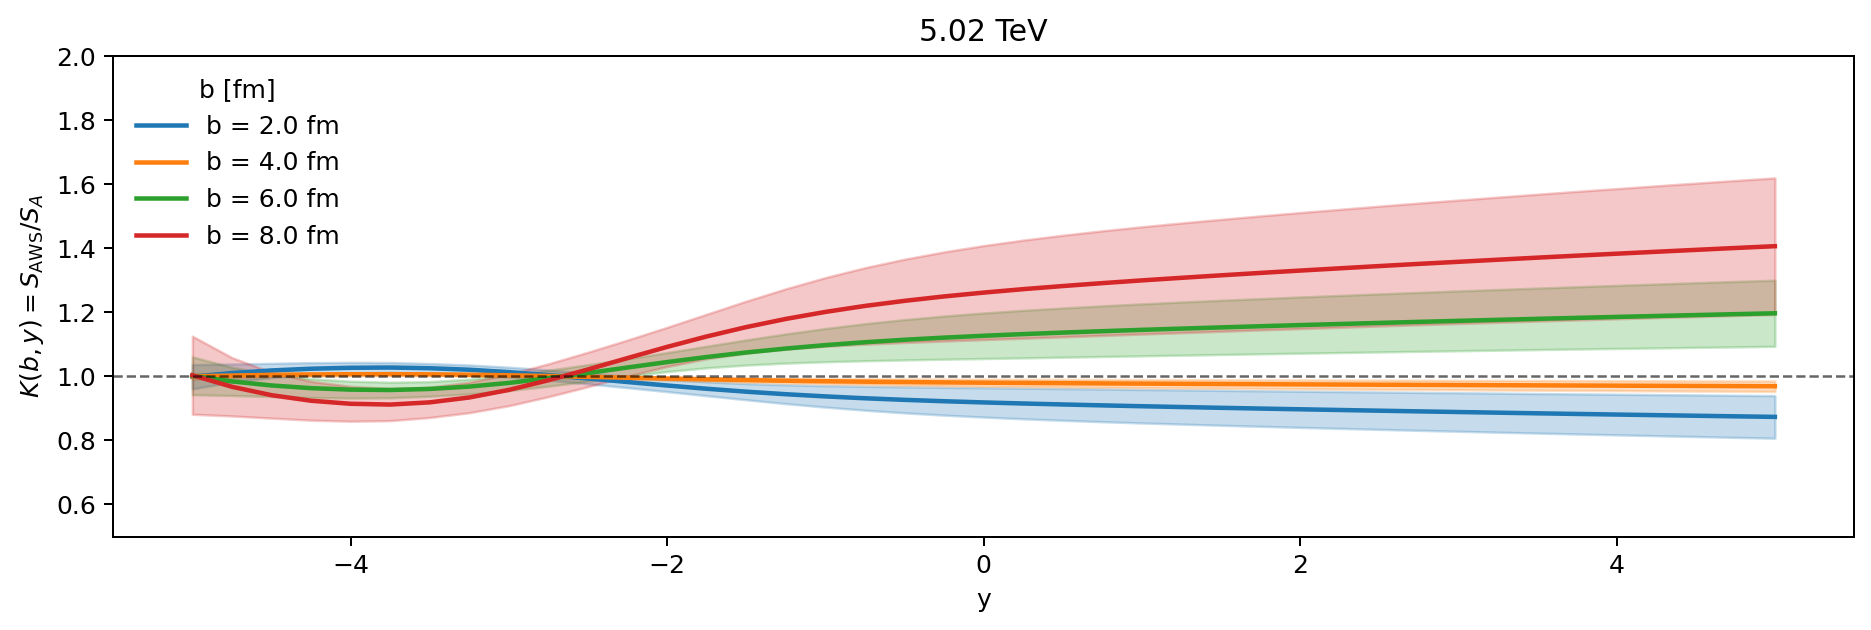

In [115]:
Y_SHIFT = 0.5

def K_band_vs_y(gprov, y_list, pt_val, b_val, y_shift=0.0):
    """
    Compute K(b,y) = S_AWS(b;y,pT) / S_A(y,pT) for all 49 EPPS21 sets
    at a fixed pT and b, on a given y grid, including the Hessian band.

    Parameters
    ----------
    gprov   : GluonEPPSProvider (epps5 or epps8)
    y_list  : 1D array-like of rapidities
    pt_val  : scalar pT [GeV]
    b_val   : impact parameter [fm]
    y_shift : Ramona-style y shift applied to S_A, S_AWS

    Returns
    -------
    K0  : central set (set_id=1), shape (Ny,)
    Klo : lower Hessian band (K0 - ΔK), shape (Ny,)
    Khi : upper Hessian band (K0 + ΔK), shape (Ny,)
    """

    y_arr = np.asarray(y_list, dtype=float)
    pt_arr = np.full_like(y_arr, float(pt_val))
    y_eff = y_arr + y_shift   # same shift convention as in your K0_KM code

    # collect all 49 sets
    K_all = []
    for sid in range(1, 50):
        SA   = gprov.SA_ypt_set(y_eff, pt_arr, set_id=sid)
        SAWS = gprov.SAWS_ypt_b_set(y_eff, pt_arr, b_val, set_id=sid)
        K_all.append(SAWS / np.clip(SA, 1e-12, None))

    K_all = np.stack(K_all, axis=0)   # (49, Ny)
    K0    = K_all[0]                  # central set
    mem   = K_all[1:, :]              # 48 error members

    # Hessian combination (pairwise: 2k, 2k+1)
    D  = mem[0::2, :] - mem[1::2, :]
    hK = 0.5 * np.sqrt(np.sum(D*D, axis=0))

    Klo = K0 - hK
    Khi = K0 + hK
    return K0, Klo, Khi

# --- Corrected Debug plot: K(b,y) vs y for several b values, 5.02 TeV ---

y_list = np.linspace(-5.0, 5.0, 41)
pt_val = 5.0        # pick a representative pT; change if you like
b_vals = [2.0, 4.0, 6.0, 8.0]

from matplotlib import colormaps
cmap = colormaps["tab10"]
colors_b = {b: cmap(i) for i, b in enumerate(b_vals)}

# 1. Unpack fig and ax from subplots(1, 1)
fig, ax = plt.subplots(1, 1, figsize=(10.5, 3.6), dpi=180) # sharey is not needed for 1 plot

# 2. Iterate over the energy/provider list directly
for ETAG, gprov in [("5.02", gprov)]: # gprov is assumed to be defined elsewhere
    
    # ETAG is "5.02" and gprov is the GluonEPPSProvider object
    
    for i, b in enumerate(b_vals):
        col = colors_b[b]

        Kc, Klo, Khi = K_band_vs_y(gprov, y_list, pt_val, b, y_shift=Y_SHIFT)

        # central line
        ax.plot(y_list, Kc, lw=1.8, color=col,
                label=fr"b = {b:.1f} fm")
        # Hessian band
        ax.fill_between(y_list, Klo, Khi,
                        color=col, alpha=0.25)

    ax.axhline(1.0, ls="--", lw=1.0, color="k", alpha=0.6)
    ax.set_xlabel("y")
    ax.set_title(f"{ETAG} TeV")

# Note: since there is only one axis object, we use 'ax' instead of 'axes[0]'
ax.set_ylabel(r"$K(b,y) = S_{\mathrm{AWS}}/S_A$")
ax.set_ylim(0.5, 2.0)

# one legend (b values)
ax.legend(frameon=False, title="b [fm]")

plt.tight_layout()
plt.show()

In [122]:
# make sure geometry is attached (lazy-init does this, but let's be explicit)
gprov.with_geometry()
b_vals = [0, 2.5, 4.5, 6.5, 8.5]
print("Nnorm =", gprov.Nnorm())
print("alpha(b=0) =", gprov.alpha_of_b(0.0))
print(np.array([gprov.alpha_of_b(b) for b in b_vals]))

Nnorm = 1.3638335895671607
alpha(b=0) = 1.0
[1.         0.92361944 0.71713448 0.25793632 0.01342098]


In [ ]:
from typing import Dict, Optional, Tuple, Union, Iterable

# --- centrality dependence ---
def SAWS_ypt_b_set(self, y, pT, b, *, set_id=1, alpha=None, Nnorm=None,
                    flav: Union[int, str] = "g"):
    """
    S_A,WS(b;y,pT) = 1 + Nnorm * (S_A - 1) * alpha(b), with central S_A from chosen set.
    """
    self._need_geom()
    SA = self.SA_ypt_set(y, pT, set_id=set_id, flav=flav)
    if alpha is None:
        alpha = self.alpha_of_b(b)
    if Nnorm is None:
        Nnorm = self.Nnorm()
    S_AWS = 1.0 + float(Nnorm) * (SA - 1.0) * float(alpha)
    # print("DEBUG: SAWS_ypt_b_set: set_id={}, b={}, alpha={}, Nnorm={}, S_A={}, S_AWS={}".format(
    #    set_id, b, alpha, Nnorm, SA, S_AWS))
    return S_AWS

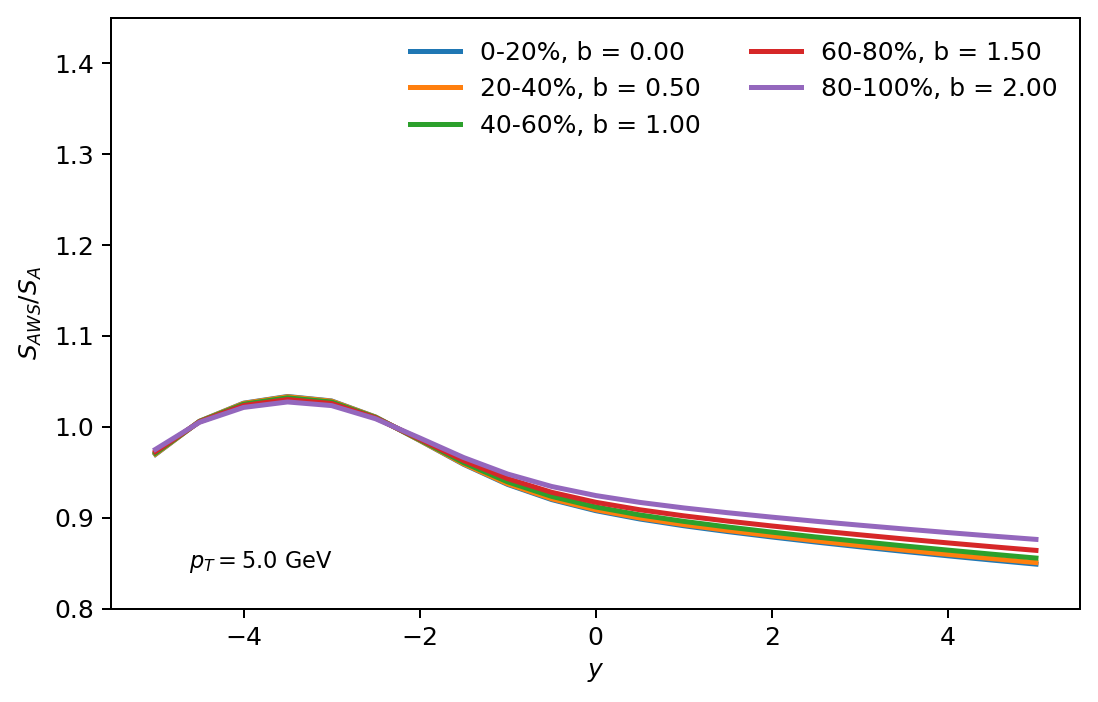

In [104]:
pT_fix = 5.0
plt.figure(figsize=(6.2,4.0), dpi=180)
ax = plt.gca()
dy = 0.5
fac = 0.25
y_list = np.arange(-5.0, +5.0+dy, dy)

for col, b, lab in zip(colors, b_list, labels):
    # central curve
    SAWS_c = gprov.SAWS_ypt_b_set(y_list+fac*dy, pT_fix, b, set_id=1)
    SA_c   = gprov.SA_ypt_set(y_list+fac*dy, pT_fix, set_id=1)
    K_c    = SAWS_c / SA_c
    K_cc = gprov.K_ypt_b_set(y_list, pT_fix, b, set_id=1)
    # band
    # K_lo, K_hi = gprov.K_band_ypt_b(y_grid, pT_fix, b, cl=68.0)
    # plot_band(ax, y_grid, K_lo, K_hi, color=col, label=None, alpha=0.22)
    new_label = f"{lab}, b = {b:.2f}"
    ax.plot(y_list, K_c, color=col, lw=2.0, label=new_label)
    # ax.plot(y_list, K_cc, color=col, linestyle='--', lw=2.5, label=b)



# Small text box for pT info
ax.text(
    0.08, 0.10,
    rf"$p_T = {pt:.1f}$ GeV",
    transform=ax.transAxes,
    va="top", ha="left",
    fontsize=9,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
)

ax.set_xlabel(r"$y$")
ax.set_ylabel(r"$S_{AWS}/S_A$")
ax.set_ylim(0.80, 1.45)
ax.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()

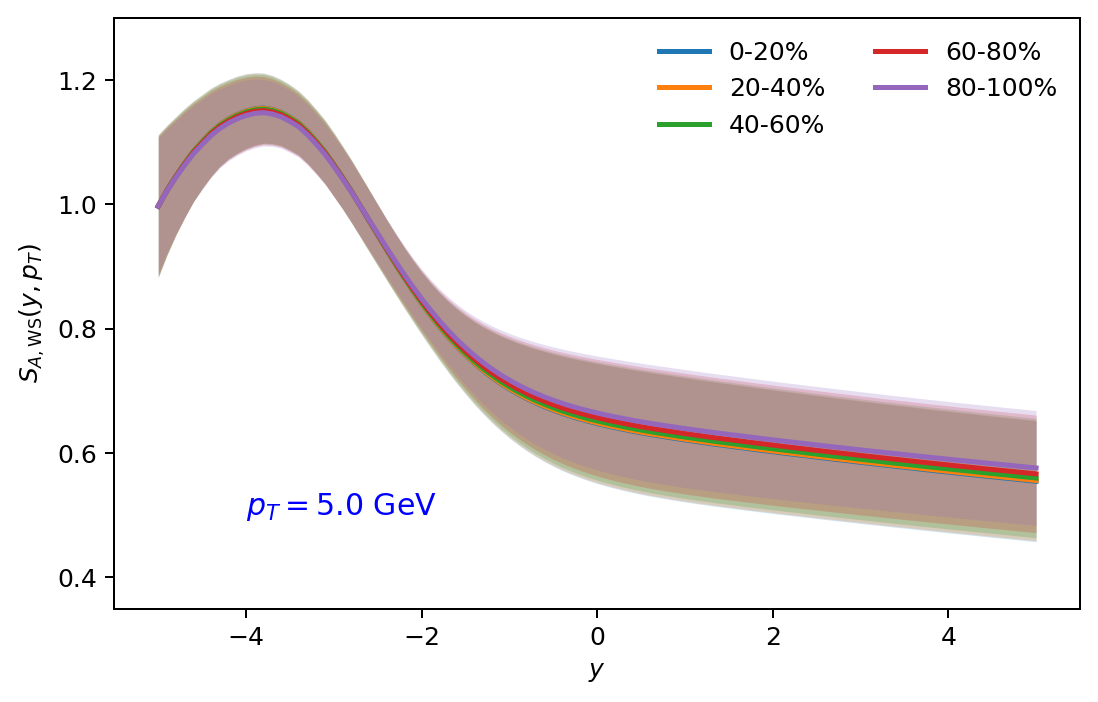

In [47]:
# kinematics
y_grid = np.linspace(-5, 5, 101)
pT_fix = 2.0

plt.figure(figsize=(6.2,4.0), dpi=180)
ax = plt.gca()

for col, b, lab in zip(colors, b_list, labels):
    SAWS_c = gprov.SAWS_ypt_b_set(y_grid, pT_fix, b, set_id=1)
    lo, hi = gprov.SAWS_band_ypt_b(y_grid, pT_fix, b, mode="symm", source="nuclear",cl=68.0)
    plot_band(ax, y_grid, lo, hi, color=col, label=None, alpha=0.22)
    ax.plot(y_grid, SAWS_c, color=col, lw=2.0, label=lab)

ax.set_xlabel(r"$y$")
ax.set_ylabel(r"$S_{A,\mathrm{WS}}(y,p_T)$")
ax.set_ylim(0.35, 1.3)
ax.legend(frameon=False, ncol=2)
plt.text(-4, 0.5, rf'$p_T = {pt}$ GeV', fontsize=12, color='blue')
plt.tight_layout()
plt.show()

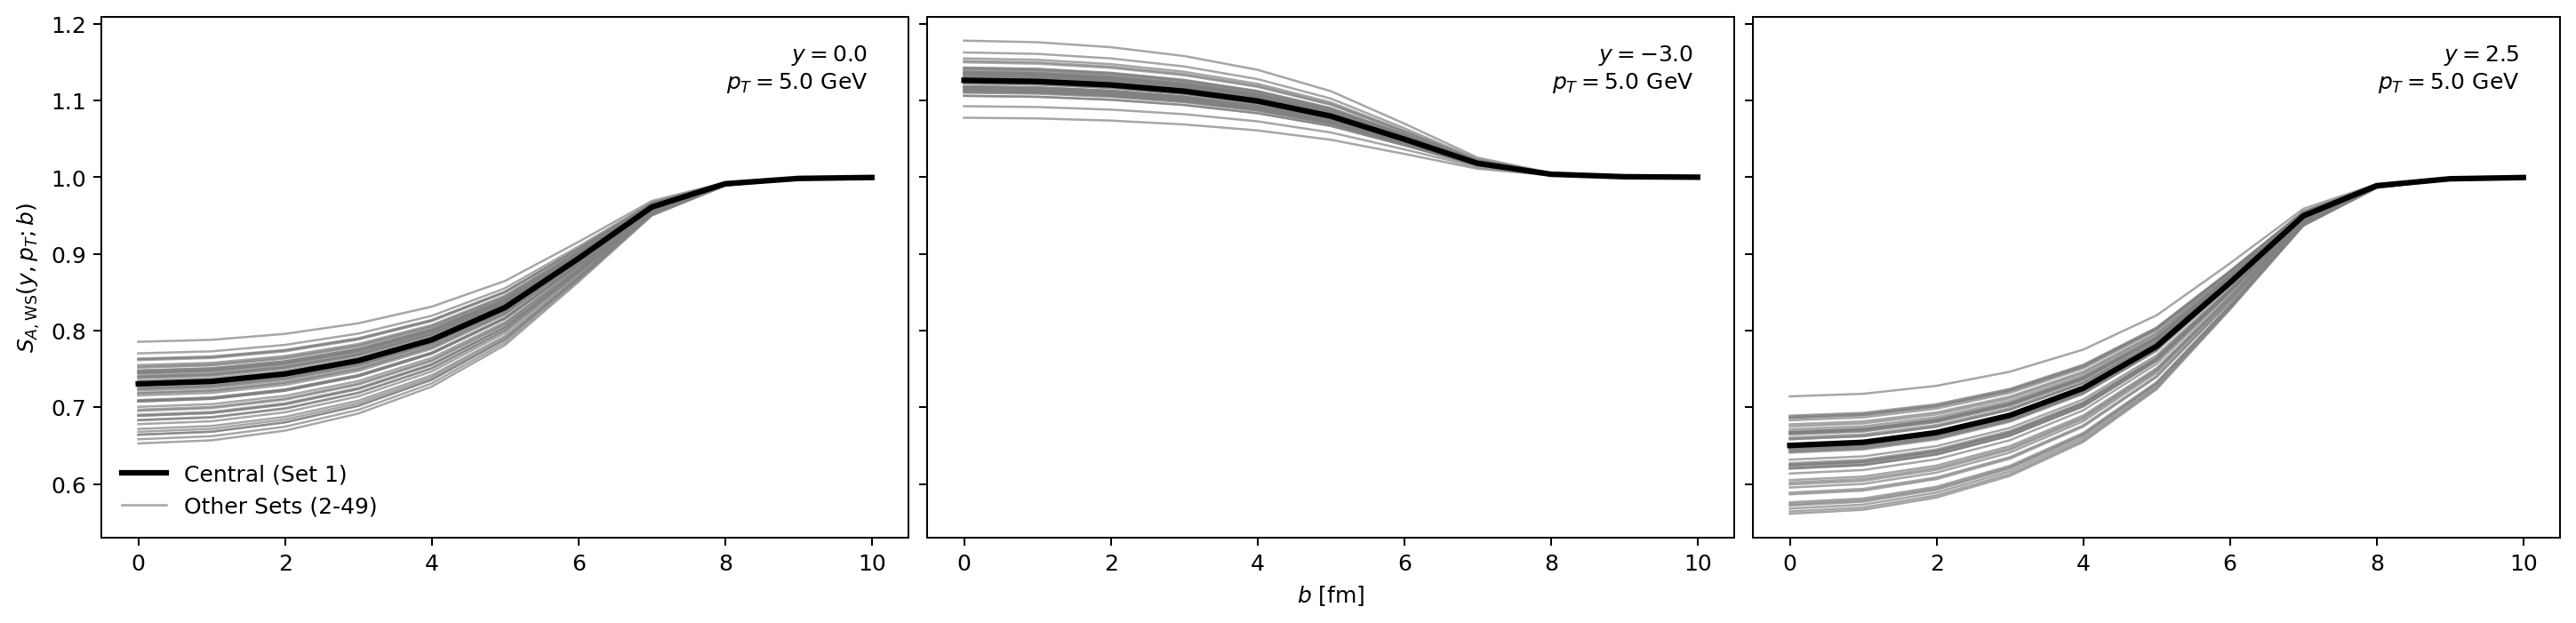

In [8]:
# 1) Define variables
b_list = np.linspace(0, 10, 11)
pT = 5.0
y_values = [0.0, -3.0, 2.5]  

# 2) Create the figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5.4 * 3, 4.0), dpi=180, sharey=True, sharex=True)

# 3) Loop over axes and y-values to plot data
for ax, y in zip(axes, y_values):
    for i in range(1, 50):
        # Calculate SAWS
        SAWS_values = np.array([gprov.SAWS_ypt_b_set(y, pT, b, set_id=i) for b in b_list])
        
        # Plot central (set 1)
        if i == 1:
            ax.plot(b_list, SAWS_values, lw=2.5, color='black', label="Central (Set 1)", zorder=50)
        # Plot other sets (2-49)
        else:
            label = "Other Sets (2-49)" if i == 2 else None
            ax.plot(b_list, SAWS_values, lw=1, color='gray', alpha=0.7, label=label, zorder=10)

    # Add text annotation to each subplot
    ax.text(0.95, 0.95, f"$y = {y:.1f}$\n$p_T = {pT:.1f}$ GeV", 
            ha='right', va='top', transform=ax.transAxes, fontsize=10)

# 4) Set common labels and the single legend
axes[1].set_xlabel(r"$b$ [fm]")
axes[0].set_ylabel(r"$S_{A,\mathrm{WS}}(y,p_T;b)$")
axes[0].legend(frameon=False, loc='lower left') # Legend now only on the first plot

# 5) Adjust layout
plt.tight_layout(w_pad=0.5)

# plt.savefig("SAWS_vs_b_subplots_horizontal.png")
plt.show()

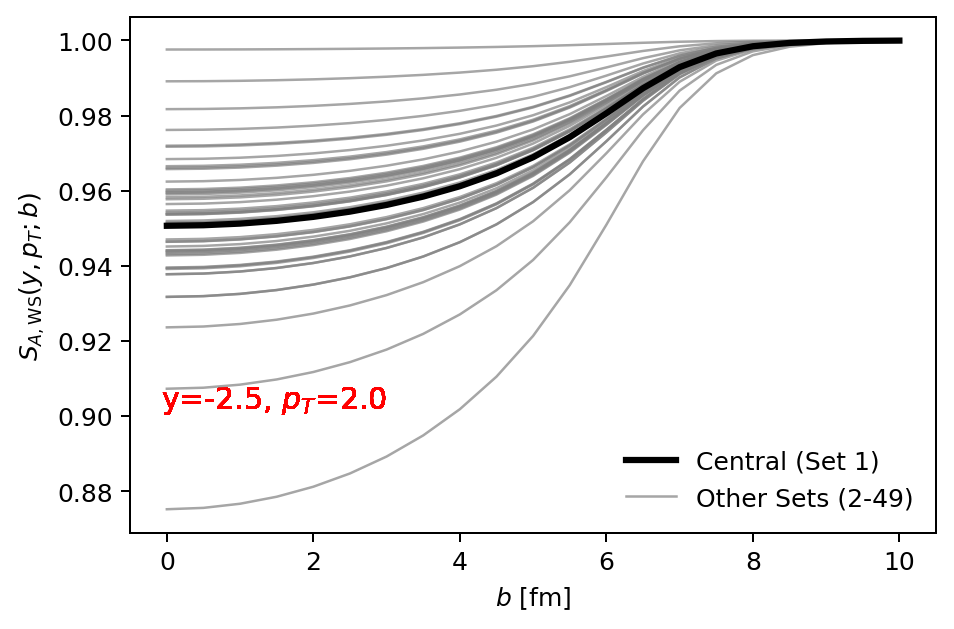

In [9]:
# 1) Define variables
b_list = np.linspace(0, 10, 21)
pT = 2.0
y = -2.5

# 2) Create the figure
plt.figure(figsize=(5.4,3.6), dpi=180)

# 3) Loop over all set_ids from 1 to 49
for i in range(1, 50):
    # Calculate SAWS for the current set_id
    SAWS_values = np.array([gprov.SAWS_ypt_b_set(y, pT, b, set_id=i) for b in b_list])
    
    if i == 1:
        # Plot set 1 (Central) darker and thicker
        plt.plot(b_list, SAWS_values, lw=2.5, color='black', label="Central (Set 1)", zorder=50)
    else:
        # Plot other sets (2-49) lighter and thinner
        label = "Other Sets (2-49)" if i == 2 else None
        plt.plot(b_list, SAWS_values, lw=1, color='gray', alpha=0.7, label=label, zorder=10)
    plt.text(3, 0.9, rf'y={y}, $p_T$={pT}', fontsize=12, color='red', ha='right', va='bottom')
# 4) Add labels and legend
plt.xlabel(r"$b$ [fm]")
plt.ylabel(r"$S_{A,\mathrm{WS}}(y,p_T;b)$")
plt.legend(frameon=False)
plt.tight_layout()

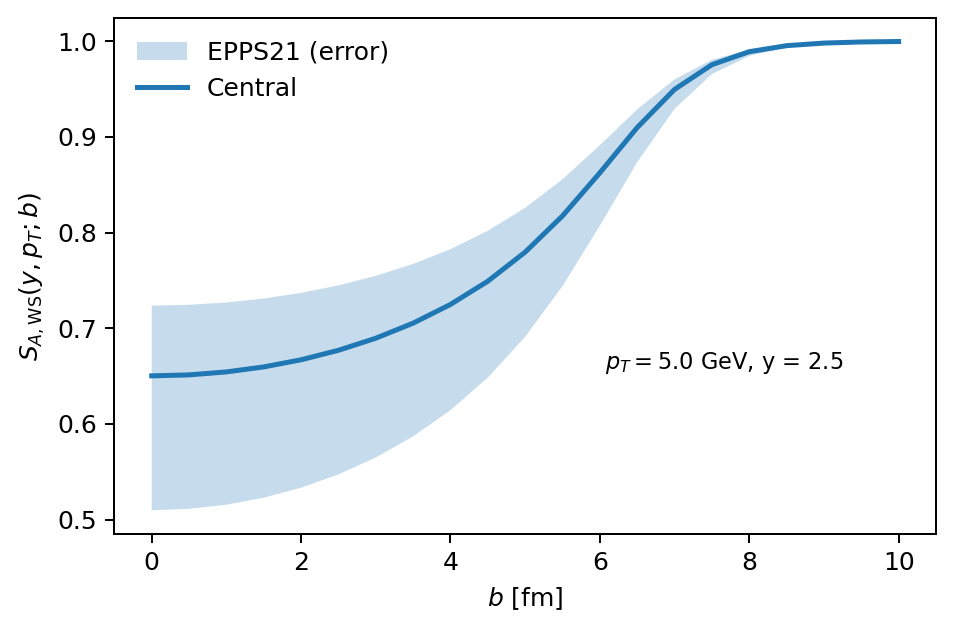

In [85]:
# 2) S_A,WS vs b at fixed (y,pT), with nuclear-only band
b_list = np.linspace(0, 10, 21)
pT = 5.0; y = 2.5
SAWS_c = np.array([gprov.SAWS_ypt_b_set(y, pT, b, set_id=1) for b in b_list])
band_list = [gprov.SAWS_band_ypt_b(y, pT, b, cl=68.0, source="nuclear") for b in b_list]
SAWS_lo, SAWS_hi = np.array(band_list, dtype=float).T
plt.figure(figsize=(5.4,3.6), dpi=180)
plt.fill_between(b_list, SAWS_lo, SAWS_hi, alpha=0.25, label="EPPS21 (error)")
plt.plot(b_list, SAWS_c, lw=2, label="Central")
# Small text box for pT info
plt.text(
    0.5, 0.30,
    rf"$p_T = {pt:.1f}$ GeV, y = {y}",
    transform=ax.transAxes,
    va="top", ha="left",
    fontsize=9,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
)
plt.xlabel(r"$b$ [fm]"); plt.ylabel(r"$S_{A,\mathrm{WS}}(y,p_T;b)$")
plt.legend(frameon=False); plt.tight_layout()

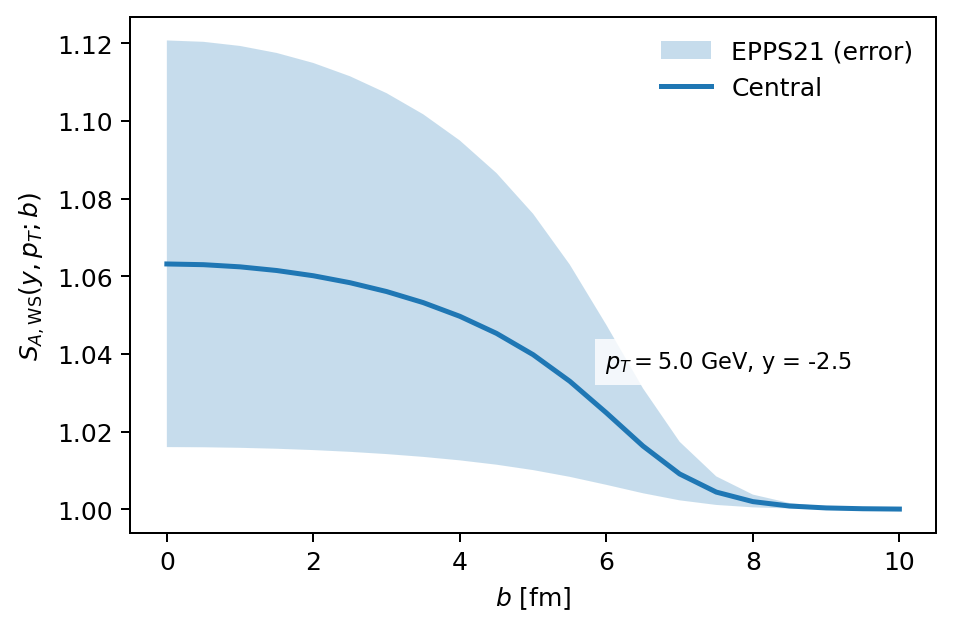

In [86]:
# 2) S_A,WS vs b at fixed (y,pT), with nuclear-only band
b_list = np.linspace(0, 10, 21)
pT = 5.0; y = -2.5
SAWS_c = np.array([gprov.SAWS_ypt_b_set(y, pT, b, set_id=1) for b in b_list])
band_list = [gprov.SAWS_band_ypt_b(y, pT, b, cl=68.0, source="nuclear") for b in b_list]
SAWS_lo, SAWS_hi = np.array(band_list, dtype=float).T
plt.figure(figsize=(5.4,3.6), dpi=180)
plt.fill_between(b_list, SAWS_lo, SAWS_hi, alpha=0.25, label="EPPS21 (error)")
plt.plot(b_list, SAWS_c, lw=2, label="Central")
# Small text box for pT info
plt.text(
    0.5, 0.30,
    rf"$p_T = {pt:.1f}$ GeV, y = {y}",
    transform=ax.transAxes,
    va="top", ha="left",
    fontsize=9,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
)
plt.xlabel(r"$b$ [fm]"); plt.ylabel(r"$S_{A,\mathrm{WS}}(y,p_T;b)$")
plt.legend(frameon=False); plt.tight_layout()

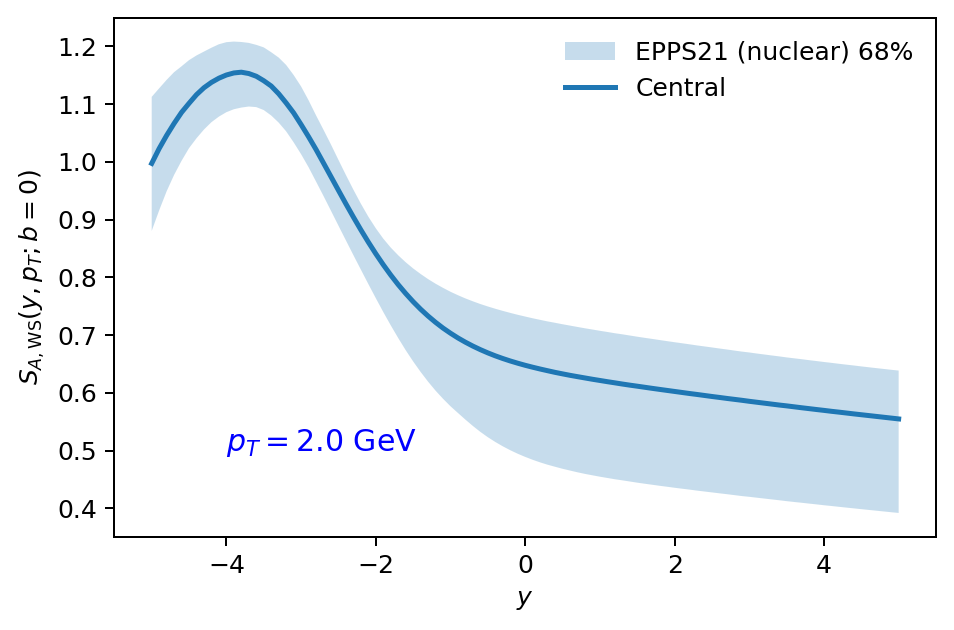

In [11]:
# 3) S_A,WS vs y at fixed pT and b
y = np.linspace(-5, 5, 101); pT = 2.0; b = 0.0
SAWS_c = gprov.SAWS_ypt_b_set(y, pT, b, set_id=1)
SAWS_lo, SAWS_hi = gprov.SAWS_band_ypt_b(y, pT, b, cl=68.0, source="nuclear")
plt.figure(figsize=(5.4,3.6), dpi=180)
plt.fill_between(y, SAWS_lo, SAWS_hi, alpha=0.25, label="EPPS21 (nuclear) 68%")
plt.text(-4, 0.5, rf'$p_T = {pT}$ GeV', fontsize=12, color='blue')
plt.plot(y, SAWS_c, lw=2, label="Central")
plt.xlabel(r"$y$"); plt.ylabel(r"$S_{A,\mathrm{WS}}(y,p_T;b{=}0)$")
plt.legend(frameon=False); plt.tight_layout()

In [12]:
# make sure geometry is attached (lazy-init does this, but let's be explicit)
gprov.with_geometry()

print("Nnorm =", gprov.Nnorm())
print("alpha(b=0) =", gprov.alpha_of_b(0.0))

# sanity: SAWS formula at b=0 for a single point
y0, pT0 = -3.0, 2.0
SA   = gprov.SA_ypt_set(y0, pT0, set_id=1)
SAWS = gprov.SAWS_ypt_b_set(y0, pT0, b=0.0, set_id=1)
print("SA(y0,pT0) =", SA, "  SAWS(b=0;y0,pT0) =", SAWS)

Nnorm = 1.3638335895671607
alpha(b=0) = 1.0
SA(y0,pT0) = 1.0473221211746204   SAWS(b=0;y0,pT0) = 1.0645394983875147


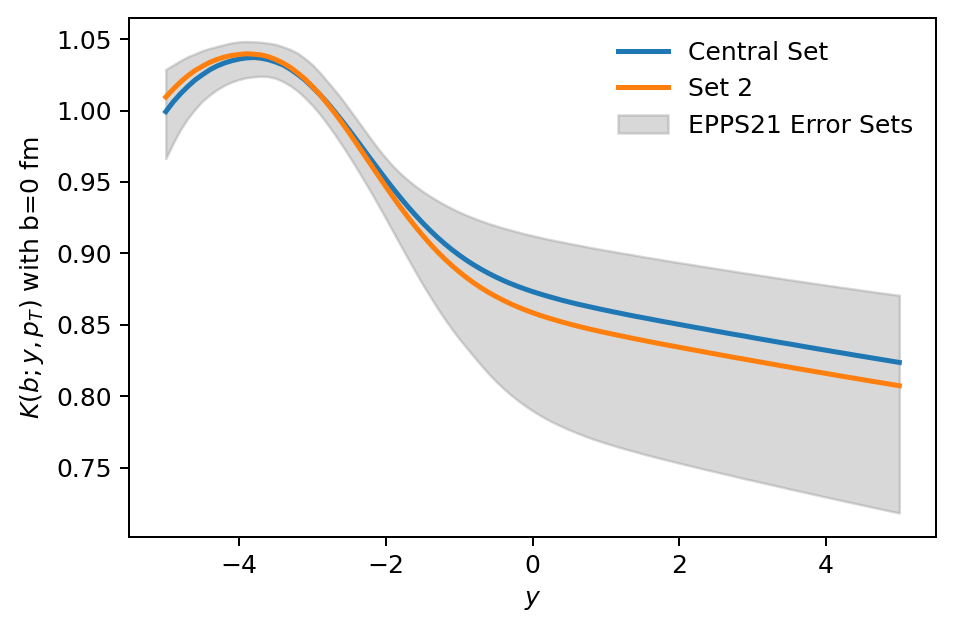

In [13]:
# --- 3C) NEW: K = SAWS / SA vs y (same kinematics/b) ---
SAWS_c = gprov.SAWS_ypt_b_set(y, pT, b, set_id=1)
SAWS_2 = gprov.SAWS_ypt_b_set(y, pT, b, set_id=2)
SAc = gprov.SA_ypt_set(y, pT, set_id=1)
SA = gprov.SA_ypt_set(y, pT, set_id=2)
K_c  = SAWS_c / np.clip(SAc, 1e-12, None)
K_2  = SAWS_2 / np.clip(SA, 1e-12, None)
K_lo, K_hi = gprov.K_band_ypt_b(y, pT, b, cl=68.0, source="nuclear")

plt.figure(figsize=(5.4,3.6), dpi=180)
plt.plot(y, K_c, lw=2, label="Central Set")
plt.plot(y, K_2, lw=2, label="Set 2")
plt.fill_between(y, K_lo, K_hi, color="gray", alpha=0.3, label="EPPS21 Error Sets")
plt.xlabel(r"$y$"); plt.ylabel(r"$K(b;y,p_T)$ with b=0 fm"); plt.legend(frameon=False); plt.tight_layout()

In [14]:
# # --- 3D) NEW: SAWS vs pT (fixed y, fixed b) ---
# pT_grid = np.linspace(0.0, 20.0, 401)
# y_fix   = -3.0
# SAWS_pt = gprov.SAWS_ypt_b_set(np.full_like(pT_grid, y_fix), pT_grid, b, set_id=1)
# plt.figure(figsize=(5.4,3.6), dpi=180)
# plt.plot(pT_grid, SAWS_pt, lw=2)
# plt.xlabel(r"$p_T$ [GeV]"); plt.ylabel(r"$S_{A,\mathrm{WS}}(y{=}-3,b{=}0)$"); plt.tight_layout()

In [15]:
# # --- 3E) NEW: K vs b at fixed (y,pT) ---
# b_grid = np.linspace(0.0, 10.0, 31)
# K_b = [gprov.K_ypt_b_set(0, 5.0, b, set_id=1) for b in b_grid]

# plt.figure(figsize=(5.4,3.6), dpi=180)
# plt.plot(b_grid, K_b, lw=2)
# plt.xlabel(r"$b$ [fm]"); plt.ylabel(r"$K(b;y{=}0,p_T{=}5)$"); plt.tight_layout()
# plt.show()

In [16]:
# # --- 3E) NEW: K vs b at fixed (y,pT) ---
# b_grid = np.linspace(0.0, 10.0, 31)
# K_b = [gprov.K_ypt_b_set(1.5, 5.0, b, set_id=1) for b in b_grid]

# plt.figure(figsize=(5.4,3.6), dpi=180)
# plt.plot(b_grid, K_b, lw=2)
# plt.xlabel(r"$b$ [fm]"); plt.ylabel(r"$K(b;y{=}1.5,p_T{=}5)$"); plt.tight_layout()
# plt.show()

In [17]:
# # --- 3E) NEW: K vs b at fixed (y,pT) ---
# b_grid = np.linspace(0.0, 10.0, 31)
# K_b = [gprov.K_ypt_b_set(-3, 5.0, b, set_id=1) for b in b_grid]

# plt.figure(figsize=(5.4,3.6), dpi=180)
# plt.plot(b_grid, K_b, lw=2)
# plt.xlabel(r"$b$ [fm]"); plt.ylabel(r"$K(b;y{=}-3,p_T{=}5)$"); plt.tight_layout()
# plt.show()

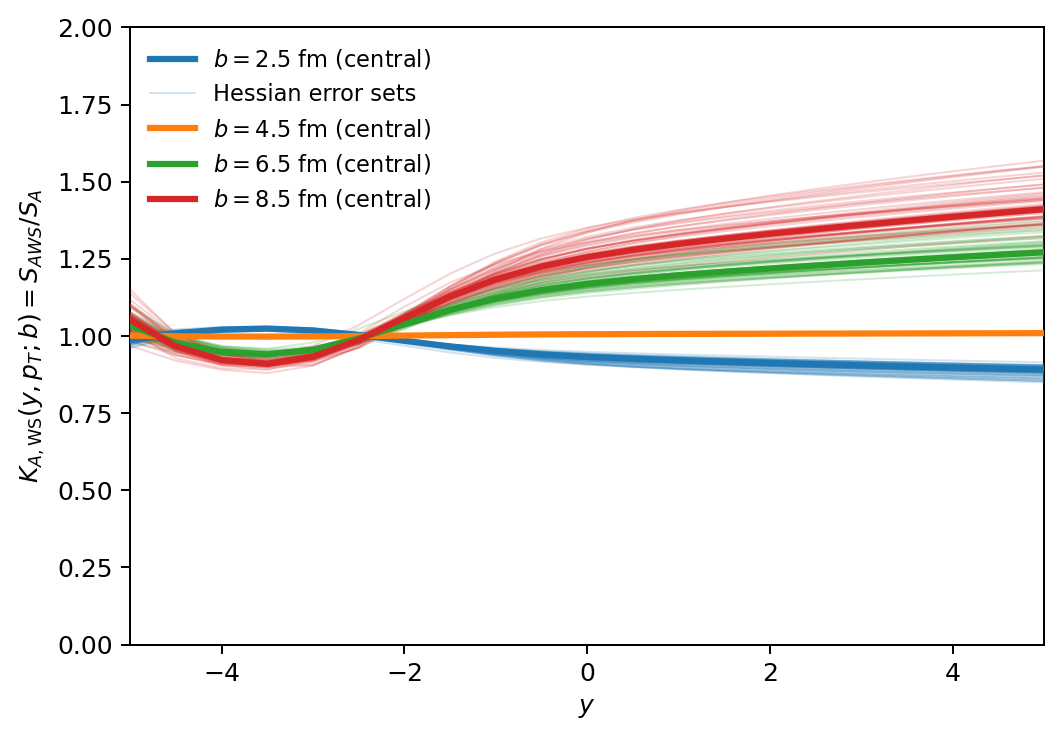

In [93]:
# --- K_AWS(y; pT, b) for different b values (central bold, others faint) ---
from matplotlib import colormaps
y_list = np.linspace(-5.0, +5.0, 21)
pT     = 5.0
b_vals = [2.5, 4.5, 6.5, 8.5]

# Give each b value a distinct color
from matplotlib.cm import get_cmap
cmap = colormaps["tab10"]
colors_b = {b: cmap(i) for i, b in enumerate(b_vals)}

plt.figure(figsize=(6.0, 4.2), dpi=180)

for bi, b in enumerate(b_vals):

    col = colors_b[b]

    # --- loop over all 49 EPPS21 sets ---
    for sid in range(1, 50):

        # K_AWS(y,pT;b,set_id)
        KAWS = np.array([gprov.K_ypt_b_set(y+0.25, pT, b, set_id=sid) for y in y_list])

        if sid == 1:
            # Central set = thick, dark
            plt.plot(
                y_list, KAWS, lw=2.5, color=col,
                label=rf"$b={b:.1f}$ fm (central)", zorder=50
            )
        else:
            # Error sets faint
            # Give label only once (sid == 2)
            lbl = "Hessian error sets" if (sid == 2 and bi == 0) else None

            plt.plot(
                y_list, KAWS, lw=0.8, color=col, alpha=0.20,
                label=lbl, zorder=5
            )

# Axis decoration
plt.xlabel(r"$y$")
plt.ylabel(r"$K_{A,\mathrm{WS}}(y,p_T;b)=S_{AWS}/S_A$")
plt.xlim(-5.0, +5.0)
plt.ylim(0.0, 2.0)

plt.legend(frameon=False, fontsize=9)
plt.tight_layout()
plt.show()

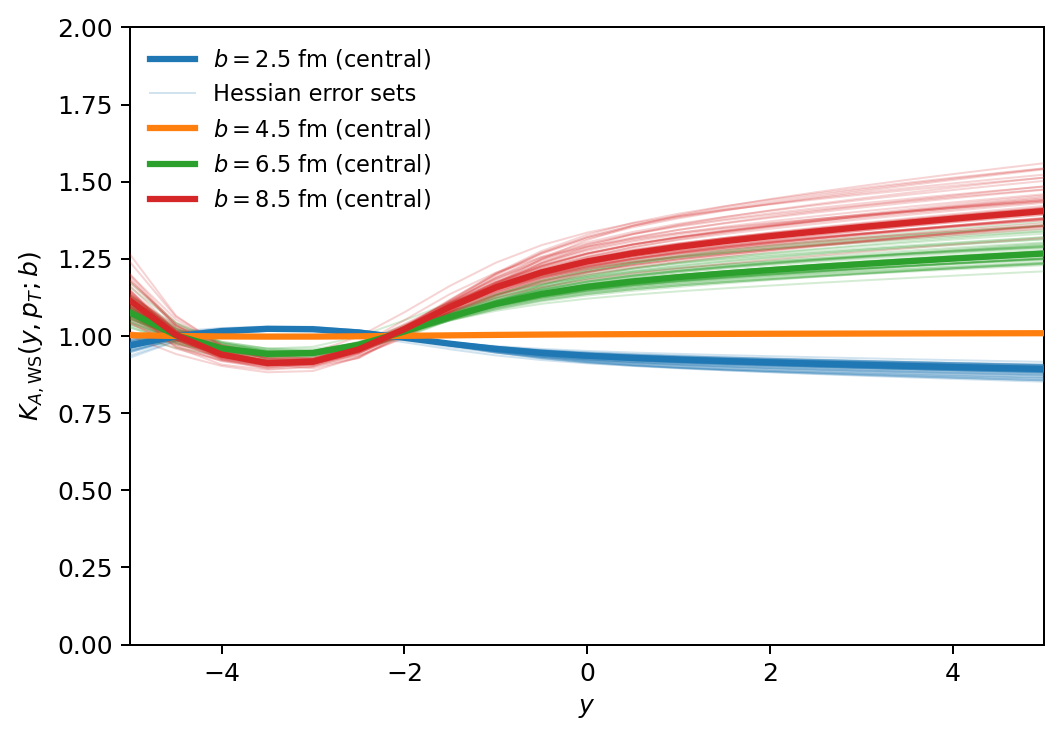

In [20]:
# --- K_AWS(y; pT, b) for different b values (central bold, others faint) ---
from matplotlib import colormaps
y_list = np.linspace(-5.0, +5.0, 21)
pT     = 5.0
b_vals = [2.5, 4.5, 6.5, 8.5]

# Give each b value a distinct color
from matplotlib.cm import get_cmap
cmap = colormaps["tab10"]
colors_b = {b: cmap(i) for i, b in enumerate(b_vals)}

plt.figure(figsize=(6.0, 4.2), dpi=180)

for bi, b in enumerate(b_vals):

    col = colors_b[b]

    # --- loop over all 49 EPPS21 sets ---
    for sid in range(1, 50):

        y_arr = y_list
        pt_arr = np.full_like(y_arr, pT, dtype=float)
        # K_AWS(y,pT;b,set_id)
        # SAWS = np.array([gprov.SAWS_ypt_b_set(y, pT, b, set_id=sid) for y in y_list])
        # SA = np.array([gprov.SA_ypt_set(y, pT, set_id=sid) for y in y_list])
        SA   = gprov.SA_ypt_set(   y_arr, pt_arr, set_id=sid)
        SAWS = gprov.SAWS_ypt_b_set(y_arr, pt_arr, b, set_id=sid)       
        KAWS = SAWS / SA

        if sid == 1:
            # Central set = thick, dark
            plt.plot(
                y_list, KAWS, lw=2.5, color=col,
                label=rf"$b={b:.1f}$ fm (central)", zorder=50
            )
        else:
            # Error sets faint
            # Give label only once (sid == 2)
            lbl = "Hessian error sets" if (sid == 2 and bi == 0) else None

            plt.plot(
                y_list, KAWS, lw=0.8, color=col, alpha=0.20,
                label=lbl, zorder=5
            )

# Axis decoration
plt.xlabel(r"$y$")
plt.ylabel(r"$K_{A,\mathrm{WS}}(y,p_T;b)$")
plt.xlim(-5.0, +5.0)
plt.ylim(0.0, 2.0)

plt.legend(frameon=False, fontsize=9)
plt.tight_layout()
plt.show()

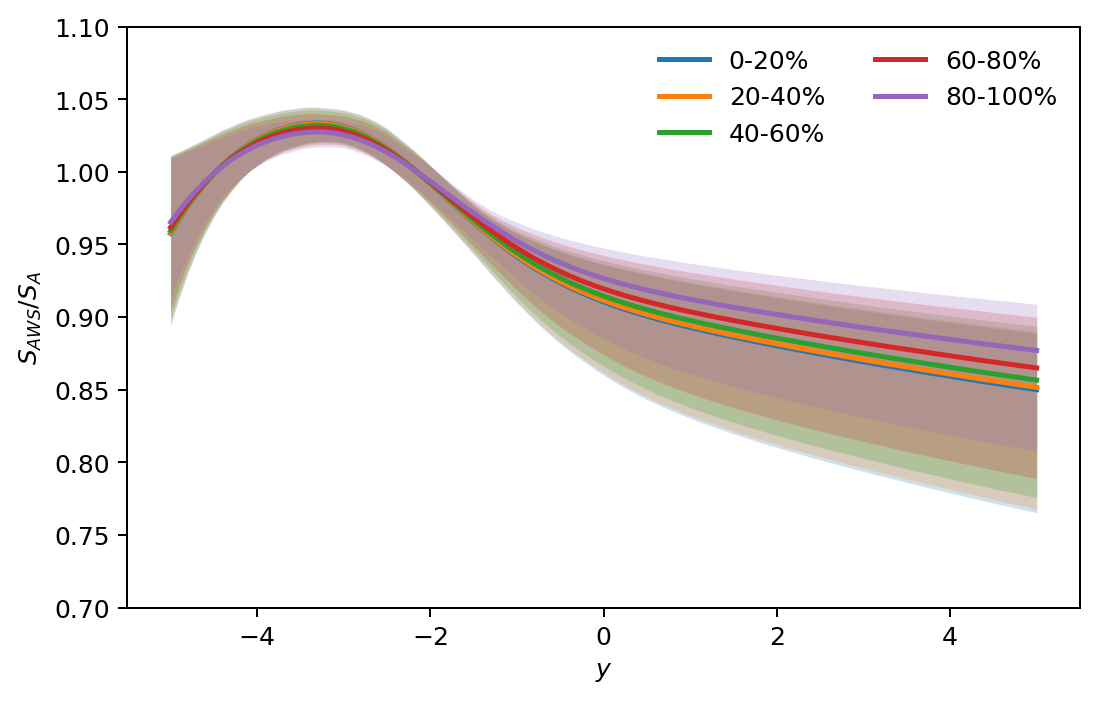

In [21]:
pT_fix = 5.0
plt.figure(figsize=(6.2,4.0), dpi=180)
ax = plt.gca()

for col, b, lab in zip(colors, b_list, labels):
    # central curve
    SAWS_c = gprov.SAWS_ypt_b_set(y_grid, pT_fix, b, set_id=1)
    SA_c   = gprov.SA_ypt_set(y_grid, np.full_like(y_grid, pT_fix), set_id=1)
    K_c    = SAWS_c / np.clip(SA_c, 1e-12, None)

    # band
    K_lo, K_hi = gprov.K_band_ypt_b(y_grid, pT_fix, b, cl=68.0)
    plot_band(ax, y_grid, K_lo, K_hi, color=col, label=None, alpha=0.22)
    ax.plot(y_grid, K_c, color=col, lw=2.0, label=lab)

ax.set_xlabel(r"$y$")
ax.set_ylabel(r"$S_{AWS}/S_A$")
ax.set_ylim(0.7, 1.1)
ax.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()

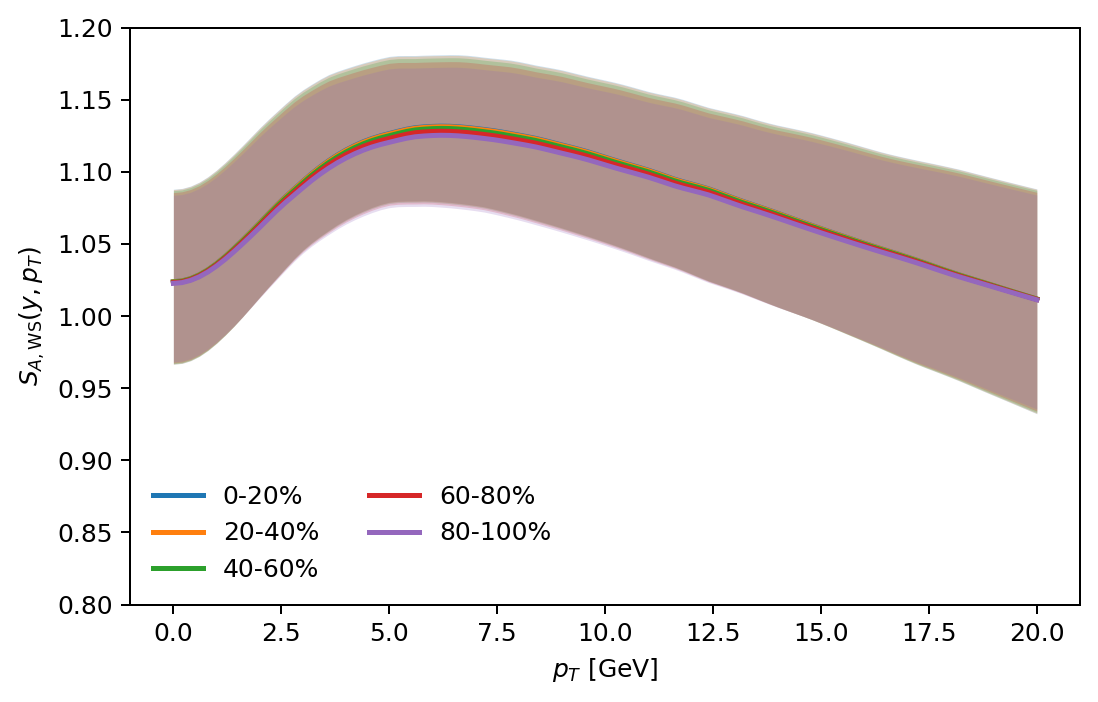

In [22]:
pT_grid = np.linspace(0.0, 20.0, 101)
y_fix   = -3.0

plt.figure(figsize=(6.2,4.0), dpi=180)
ax = plt.gca()

for col, b, lab in zip(colors, b_list, labels):
    SAWS_c = gprov.SAWS_ypt_b_set(y_fix, pT_grid, b, set_id=1)
    lo, hi = gprov.SAWS_band_ypt_b(y_fix, pT_grid, b, cl=68.0)
    plot_band(ax, pT_grid, lo, hi, color=col, label=None, alpha=0.22)
    ax.plot(pT_grid, SAWS_c, color=col, lw=2.0, label=lab)

ax.set_xlabel(r"$p_T$ [GeV]")
ax.set_ylabel(r"$S_{A,\mathrm{WS}}(y,p_T)$")
ax.set_ylim(0.80, 1.2)
ax.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()

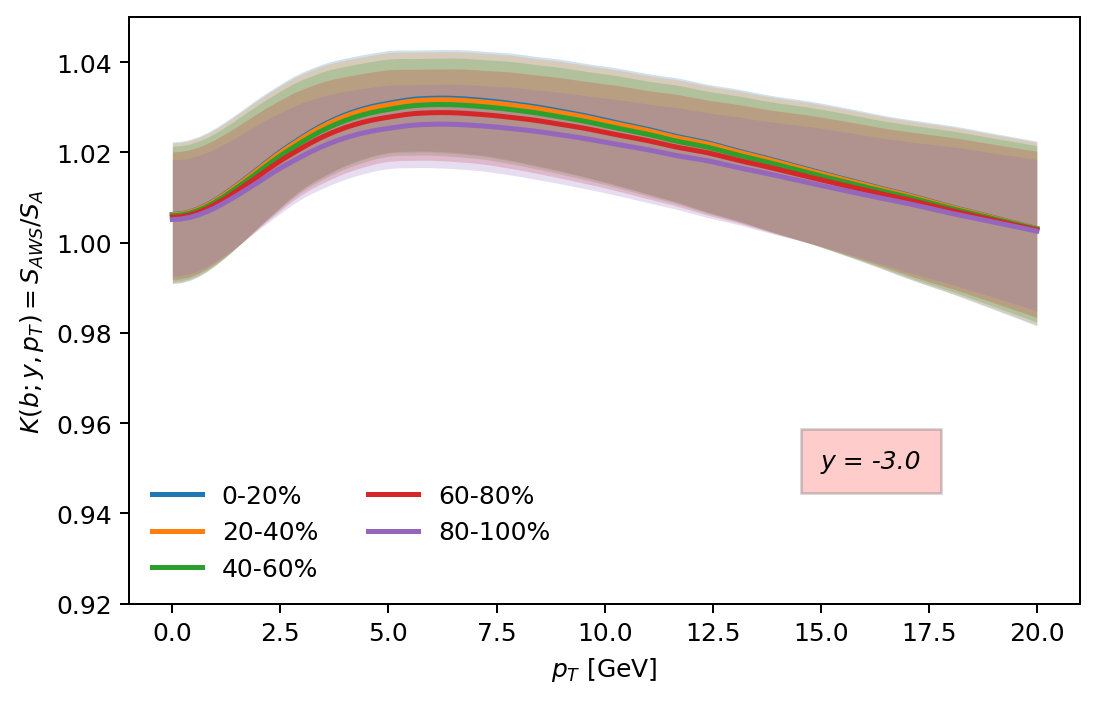

In [23]:
plt.figure(figsize=(6.2,4.0), dpi=180)
ax = plt.gca()

for col, b, lab in zip(colors, b_list, labels):
    SAWS_c = gprov.SAWS_ypt_b_set(y_fix, pT_grid, b, set_id=1)
    SA_c   = gprov.SA_ypt_set(y_fix, pT_grid, set_id=1)
    K_c    = SAWS_c / np.clip(SA_c, 1e-12, None)

    # band
    K_lo, K_hi = gprov.K_band_ypt_b(y_fix, pT_grid, b, cl=68.0)
    plot_band(ax, pT_grid, K_lo, K_hi, color=col, label=None, alpha=0.22)
    ax.plot(pT_grid, K_c, color=col, lw=2.0, label=lab)

ax.set_xlabel(r"$p_T$ [GeV]")
ax.set_ylabel(r"$K(b;y,p_T)=S_{AWS}/S_A$")
ax.text(15, 0.95, f'y = {y_fix}', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.2, 'pad': 8})
ax.set_ylim(0.92, 1.05)
ax.legend(frameon=False, ncol=2)
plt.tight_layout()

## Other: Quarks

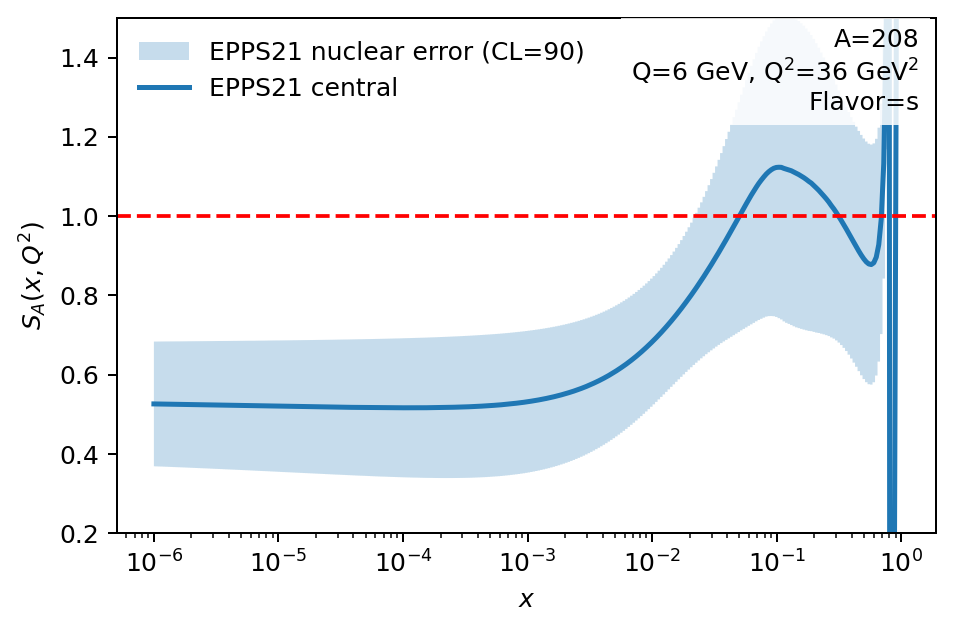

In [24]:
fig, ax = epps.plot_SA_vs_x("s", x, Q)
ax.set_ylim(0.20, 1.5)
ax.axhline(y=1.0, color='r', linestyle='--', linewidth=1.5)
plt.show()

(-0.5, 1.0)

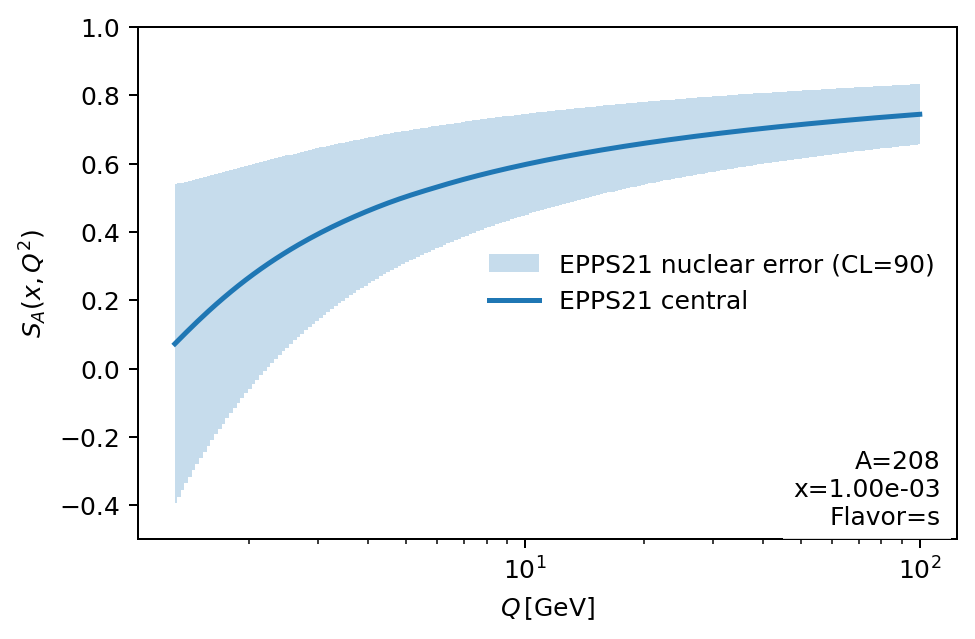

In [25]:
# 2) Quark ratios too (e.g., strange)
Qgrid = np.logspace(np.log10(1.3), 2, 200)
fig, ax = epps.plot_SA_vs_Q("s", Qgrid, x=1e-3)  # 68% CL = 90%/1.645
ax.set_ylim(-0.5, 1.0)